Выполнила: Тихонова Анна, 4 сложная

# Машинное обучение, ФЭН ВШЭ

__Дата выдачи: 26.11.2017__
__Дедлайн: 15.12.2017 23:59__

# Практическое задание 4


### О задании

Практическое задание 4 посвящено ансамблям, bias-variance decomposition, деревьям и нейронным сетям. Обучение нейронных сетей займет какое-то время, поэтому не оставляйте эту часть на последний день!

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW4_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW4_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [1]:
import numpy as np

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [2]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

36.107218604195381

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [3]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

20.382917427411268

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
#####  Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1 (0.6 балла)__
1. Сгенерируйте выборку x из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных y как сумму f(x) и случайного шума, сгенерированного из равномерного распределения на отрезке [-1, 1] (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: f(x) и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

In [6]:
x = np.random.exponential(size = sample_size)

In [7]:
y = f(x) + np.random.uniform(low=-1, high=1, size=sample_size)

In [8]:
from sklearn.tree import DecisionTreeRegressor

In [9]:
dtree = DecisionTreeRegressor()
pred = dtree.fit(x.reshape(-1, 1), y).predict(linspace.reshape(-1, 1))

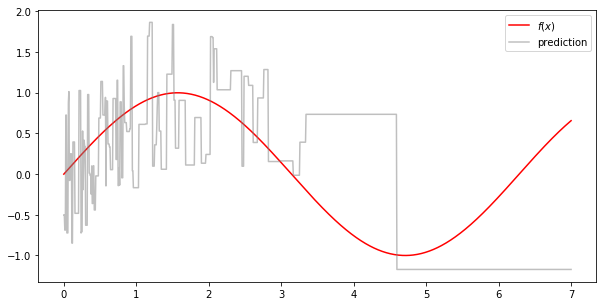

In [10]:
plt.figure(figsize=(10,5))
plt.plot(linspace, f(linspace), label='$f(x)$', color = 'r')
plt.plot(linspace, pred, label='prediction', color = 'grey', alpha = 0.5)

plt.legend();

__2 (0.6 балла):__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

In [11]:
def plot_for__dif_params(regr):
    plt.figure(1, figsize=[13, 5])

    trees = []
    for i in range(samples_num):  
        x = np.random.exponential(size = sample_size)
        y = f(x) + np.random.uniform(size = sample_size, low = -1, high = 1)
        dtree = regr.fit(x.reshape(-1, 1), y).predict(linspace.reshape(-1, 1))
        trees.append(dtree)
        plt.plot(linspace, dtree, color='gray', alpha=0.5, linewidth =  0.5)
    plt.plot(linspace, np.mean(trees, 0), color='black', linewidth =  0.9)
    plt.plot(linspace, f(linspace), color='red', linewidth =  2)
    plt.show()

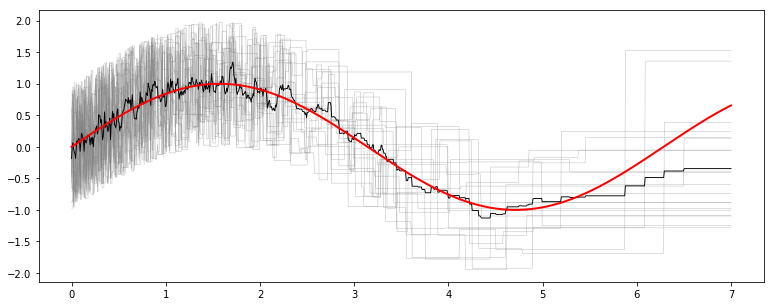

In [12]:
plot_for__dif_params(DecisionTreeRegressor())

__3 (0.2 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

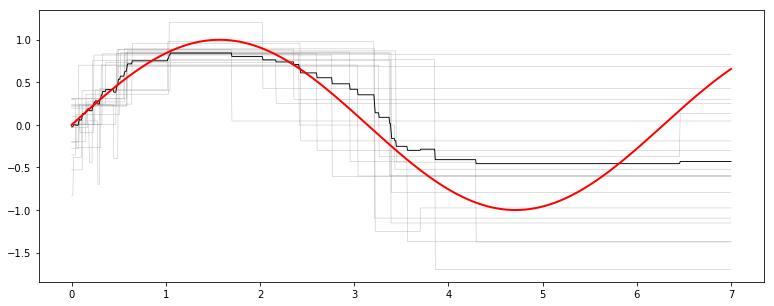

In [13]:
plot_for__dif_params(DecisionTreeRegressor(max_depth=2))

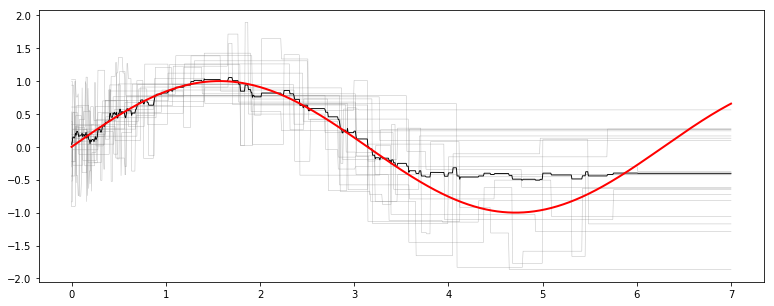

In [14]:
plot_for__dif_params(DecisionTreeRegressor(max_depth=4))

__4 (0.6 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

- Наиболее близким к нулю смещение будет в случае, когда отсутсвует ограничение на глубину дерева.Это происхоит потому, что смещение отражает отличие используемого алгоритма предсказания от алгоритма, идеально предсказывающего зависимости исходных данных. 

- По полученным выше графикам видно, что в первом случае смещение наименьшее, так как нет ограничений грубины, а дначит деревья могут иметь большую глубину, чем во втором и третем случаях.

__5 (1 балл)__
Проделайте тот же эксперимент с линейной регрессией и SVM с rbf ядром и параматрами $\gamma = 1$, $\gamma = 100$. Какие выводы можно сделать?

In [15]:
from sklearn.linear_model import LinearRegression

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


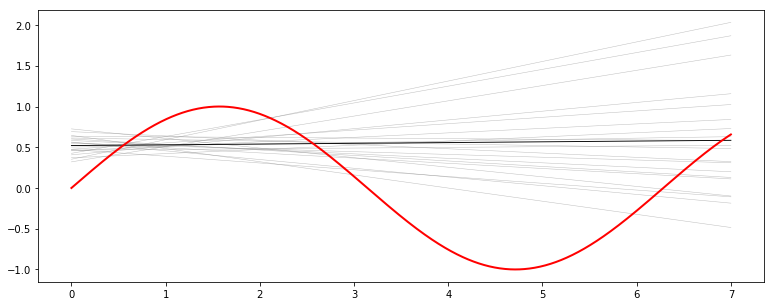

In [16]:
plot_for__dif_params(LinearRegression())

In [17]:
from sklearn.svm import SVR

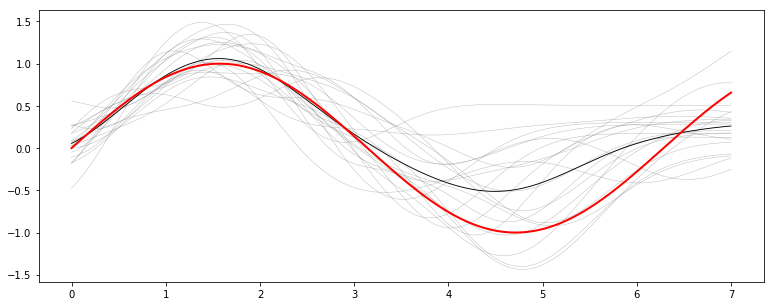

In [18]:
plot_for__dif_params(SVR(kernel='rbf', gamma=1))

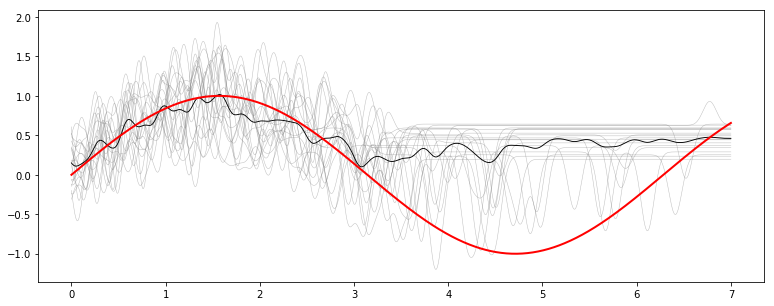

In [19]:
plot_for__dif_params(SVR(kernel='rbf', gamma=100))

- Функция, которую мы предсказывали является нелинейной, а значит использование линейной регрессии в данном случае не даст никаких адекватных результатов. То есть смещение слишком большое;

- Далее мы использовали для предсказания SVR. При γ=1 смещение наблюдается небольшое, достаточно хорошо может приблизить форму графика предсказываемой функции, то есть из рассмотренных методов дает наиболее близкий к реальным данным результат.

- SVR с γ=100 будет приводить к переобучению, то есть результат на тестовой выборке будет плохим, смещение на тестовой достаточно большое, плохо будет предсказана форма графика предсказываемой функции.

### II. Решающие деревья

__5 (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassfier, считающий все признаки категориальными
* DecisionTreeClassifier, c корректным разбиением на категориальные и вещественные признаки.

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.

In [29]:
import pandas as pd 
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, ShuffleSplit

In [21]:
from sklearn.preprocessing import LabelEncoder

In [22]:
mushrooms = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data',header=None)
tic_tac_toe = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data',header=None)
cars = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data',header=None)
nursery = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data',header=None)

In [23]:
from sklearn import preprocessing

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [31]:
cv = ShuffleSplit(n_splits= 10, test_size=0.3, random_state=14)

#### mushrooms

In [32]:
mushrooms_y = preprocessing.LabelEncoder().fit_transform(mushrooms[0])
mushrooms_x = mushrooms.loc[:,1:]

Закодируем как категориальные

In [33]:
mushrooms_for_c = mushrooms.drop([0], axis=1)

In [34]:
len(mushrooms.columns)

23

In [35]:
col = list(range(1,23))
mushrooms_categ = np.array(pd.get_dummies(mushrooms_for_c, columns=col, dummy_na=True))

Вещественные:

In [36]:
mushrooms_real=pd.DataFrame()
for i in mushrooms_x.columns:
    mushrooms_real =pd.concat([mushrooms_real, pd.DataFrame(preprocessing.LabelEncoder().fit_transform(mushrooms_x[i]))], axis = 1)

##### Определим качество:

Категориальные:

In [37]:
np.mean(cross_val_score(X=mushrooms_categ, y=mushrooms_y, estimator=DecisionTreeClassifier(), cv=10, scoring='accuracy'))

0.95642844467902144

Вещественные:

In [38]:
np.mean(cross_val_score(X=mushrooms_real, y=mushrooms_y, estimator=DecisionTreeClassifier(), cv=10, scoring='accuracy'))

0.96259306612794848

Точность в слчае, когда мы считаем все признаки вещественными ниже, что логично, так как в исходном датасете категориальные признаки не упорядочены, а значит мы кодируем с помощью LabelEncoder несравнисые между собой признами.

#### tic_tac_toe

In [39]:
tic_tac_toe_y = preprocessing.LabelEncoder().fit_transform(tic_tac_toe[9])
tic_tac_toe_x = tic_tac_toe.loc[:, :8]

Вещественные:

In [40]:
tic_tac_toe_for_c = tic_tac_toe.drop([9], axis=1)

In [41]:
tic_tac_toe_real=pd.DataFrame()
for i in tic_tac_toe_x.columns:
    tic_tac_toe_real =pd.concat([tic_tac_toe_real, pd.DataFrame(preprocessing.LabelEncoder().fit_transform(tic_tac_toe_x[i]))], axis = 1)

Категориальные:

In [42]:
col = list(range(tic_tac_toe_for_c.shape[1]))
tic_tac_toe_categ = np.array(pd.get_dummies(tic_tac_toe_for_c, columns=col, dummy_na=True))

##### Определим качество:

Категориальные:

In [43]:
np.mean(cross_val_score(X=tic_tac_toe_categ, y=tic_tac_toe_y, estimator=DecisionTreeClassifier(), cv=10, scoring='accuracy'))

0.80812737384698852

Вещественные:


In [44]:
np.mean(cross_val_score(X=tic_tac_toe_real, y=tic_tac_toe_y, estimator=DecisionTreeClassifier(), cv=10, scoring='accuracy'))

0.76562556520166392

Аналогично предыдущему случаю, точно сть снижается при кодировании неупорядоченных категориальных признаков как вещественных.

#### cars

In [45]:
cars[6].value_counts()

unacc    1210
acc       384
good       69
vgood      65
Name: 6, dtype: int64

In [46]:
cars_y = preprocessing.LabelEncoder().fit_transform(cars[6])
cars_x = cars.loc[:, :5]

In [47]:
cars_for_c = cars.drop([6], axis=1)

In [48]:
cars[6] = cars[6].replace(to_replace=['unacc', 'vgood'], value=['acc', 'good'])
nursery[8] = nursery[8].replace(to_replace=['recommend', 'very_recom', 'spec_prior'], value=['not_recom', 'priority', 'priority'])

Вещественные:

In [49]:
cars_real=pd.DataFrame()
for i in cars_x.columns:
    cars_real =pd.concat([cars_real, pd.DataFrame(preprocessing.LabelEncoder().fit_transform(cars_x[i]))], axis = 1)

В данном наборе значения признаков можно считать упорядоченными, однако если их кодировать так, как представлено выше, то ни одна из этих кодировок не будет учитывать этой упорядоченности, так как чтобы ее учесть,надо понимать какая категория что значит. Поэтому сделаем кодировку вручную.

In [50]:
cars_r = cars_x.copy()

cars_r[cars_r == 'low'] = 0
cars_r[cars_r == 'small'] = 0

cars_r[cars_r == 'med'] = 1

cars_r[cars_r == 'high'] = 2
cars_r[cars_r == 'big'] = 2

cars_r[cars_r == 'vhigh'] = 3

cars_r[cars_r == '5more'] = 5
cars_r[cars_r == 'more'] = 5

Категориальные:

In [51]:
col = list(range(cars_for_c.shape[1]))
cars_categ = np.array(pd.get_dummies(cars_for_c, columns=col, dummy_na=True))

##### Определим качество:

Категориальные:

In [52]:
np.mean(cross_val_score(X=cars_categ, y=cars_y, estimator=DecisionTreeClassifier(), cv=10, scoring='accuracy'))

0.84579563510990408

Перемешаем:

In [53]:
np.mean(cross_val_score(X=cars_categ, y=cars_y, estimator=DecisionTreeClassifier(), cv= cv, scoring='accuracy'))

0.96917148362235062

Вещественные при кодировке вручную:

In [54]:
np.mean(cross_val_score(X=cars_r, y=cars_y, estimator=DecisionTreeClassifier(), cv=10, scoring='accuracy'))

0.88735526260896547

Перемешаем:

In [55]:
np.mean(cross_val_score(X=cars_r, y=cars_y, estimator=DecisionTreeClassifier(), cv=cv, scoring='accuracy'))

0.97803468208092492

Вещественные без учета реальных категорий:

In [56]:
np.mean(cross_val_score(X=cars_real, y=cars_y, estimator=DecisionTreeClassifier(), cv=10, scoring='accuracy'))

0.86789276381423797

Перемешаем:

In [57]:
np.mean(cross_val_score(X=cars_real, y=cars_y, estimator=DecisionTreeClassifier(), cv=cv, scoring='accuracy'))

0.97803468208092492

Качество получилось выше всего при кодировании с помощью LabelEncoder при обработке данных вручную. Так как в этом датасете данные можно упорядочить, то простое созданние дамми на все признаки будет наихудшим вариантом кодирования. Если же просто применить LabelEncoder, токачество становится лучше, однако, он так же не учитывает упорядоченность в том смысле, которое нам необходимо здесь. Так что только ручное кодирование упорядоченного набора с учетом смысла всех признаков даст хорошие результат предсказания.

 #### nursery

In [58]:
nursery[8].value_counts()

priority     8638
not_recom    4322
Name: 8, dtype: int64

In [59]:
nursery_y = preprocessing.LabelEncoder().fit_transform(nursery[8])
nursery_x = nursery.loc[:, :7]

Вещественные:

In [60]:
nursery_for_c = nursery.drop([8], axis=1)

In [61]:
nursery_real=pd.DataFrame()
for i in nursery_x.columns:
    nursery_real =pd.concat([nursery_real, pd.DataFrame(preprocessing.LabelEncoder().fit_transform(nursery_x[i]))], axis = 1)

А теперь закодируем вручную так же как и делали в машинами:

In [62]:
nursery_r = nursery_x.copy()

nursery_r[nursery_r == 'usual'] = 0
nursery_r[nursery_r == 'very_crit'] = 0
nursery_r[nursery_r == 'complete'] = 0
nursery_r[nursery_r == 'critical'] = 0
nursery_r[nursery_r == 'not_recom'] = 0
nursery_r[nursery_r == 'problematic'] = 0

nursery_r[nursery_r == 'pretentious'] = 1
nursery_r[nursery_r == 'critical'] = 1
nursery_r[nursery_r == 'completed'] = 1
nursery_r[nursery_r == 'less_conv'] = 1
nursery_r[nursery_r == 'inconv'] = 1
nursery_r[nursery_r == 'priority'] = 1
nursery_r[nursery_r == 'slightly_prob'] = 1

nursery_r[nursery_r == 'great_pret'] = 2
nursery_r[nursery_r == 'improper'] = 2
nursery_r[nursery_r == 'incomplete'] = 2
nursery_r[nursery_r == 'convenient'] = 2
nursery_r[nursery_r == 'recommended'] = 2
nursery_r[nursery_r == 'nonprob'] = 2

nursery_r[nursery_r == 'less_proper'] = 3
nursery_r[nursery_r == 'foster'] = 3

nursery_r[nursery_r == 'proper'] = 4
nursery_r[nursery_r == 'more'] = 4

Категориальные:

In [63]:
col = list(range(nursery_for_c.shape[1]))
nursery_categ = np.array(pd.get_dummies(nursery_for_c, columns=col, dummy_na=True))

##### Определим качество:

Вещественные без учета реальных категорий:

In [64]:
np.mean(cross_val_score(X=nursery_real, y=nursery_y, estimator=DecisionTreeClassifier(), cv=10, scoring='accuracy'))

0.99969147700771965

Перемешаем:

In [65]:
np.mean(cross_val_score(X=nursery_real, y=nursery_y, estimator=DecisionTreeClassifier(), cv=cv, scoring='accuracy'))

0.99971707818930022

Вещественные при кодировке вручную:

In [66]:
np.mean(cross_val_score(X=nursery_r, y=nursery_y, estimator=DecisionTreeClassifier(), cv=10, scoring='accuracy'))

0.99969147700771965

Перемешаем:

In [67]:
np.mean(cross_val_score(X=nursery_r, y=nursery_y, estimator=DecisionTreeClassifier(), cv=cv, scoring='accuracy'))

0.99994855967078189

Категориальные:

In [68]:
np.mean(cross_val_score(X=nursery_categ, y=nursery_y, estimator=DecisionTreeClassifier(), cv=10, scoring='accuracy'))

0.99953715602006521

Перемешаем:

In [69]:
np.mean(cross_val_score(X=nursery_categ, y=nursery_y, estimator=DecisionTreeClassifier(), cv=cv, scoring='accuracy'))

0.99987139917695467

Соотношения полученные при измерении качества предсказания получились такие же как в предыдущем случае. То есть самое низкое качество будет при кодировании признаков как категориальных, затем идет кодирование как вещественных, но без учета реального деления на категории и затем уже вещественные при ручном кодировании с учетом существующих в исходных данных градаций катерогий признаков.

__6 (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

Итак, после того как мы посчитали качество при разных способах кодирования данных, можем сделать следующие общие выводы.
Учет признаков как категориальных, то есть создание дамми переменных для всех признаков, будет давать лучший результат в сравнение с другими рассмотренными вариантами кодирования только в случае, когда исходные признаки категориальные и не сравнимы. Примером могут быть датасеты mushrooms и tic-tac-toe, где признаки действительно никак нельзя сравнить и поэтому дамми кодирование дает наивысший результат.
Если же в датасете есть сравнивые между собой категориальные признаки, как например в датасетах cars и nursery, то создание дамми переменных на признаки будет давать самый плохой результат. Так как признаки можно упорядочить, а дамми переменные это никак не учитывают, то теряется важная взаимосвязь признаков, что приводит к низким значениям accuracy. Если закодировать "автоматически" признаки как вещественные, то есть просто применить labelencoder, то качество получается выше, однако не учтена реальная ранжированность категорий. Наилучший результат можно получить при кодировании признаков вручную, то есть с учетом зависимости в исходных данных. 

Так как мы оцениваем качество алгоритмов используя кросс-валидацию, то если использовать не перемешанную выборку, которая была упорядочена по признакам некоторым, то мы получием более низкое качество алгоритма, так как разбиение может быть выбрано не подходящим образом, что бы привело к неверным оценкам результатов. То есть без перемешивания могли бы получиться неправильные выводы о качестве алгоритмов, что могло бы привести к вообще неправильным результатам. 

### III. Композиции деревьев
#### Сравнение композиционных методов над решающими деревьями
__7 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [70]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [71]:
wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [72]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [73]:
y = np.array(wine['quality'])
X = np.array(wine.drop('quality', axis=1))

In [74]:
from sklearn.model_selection import cross_val_score, ShuffleSplit

In [75]:
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)

In [76]:
d_tree = cross_val_score(estimator = DecisionTreeClassifier(), cv=cv, scoring = 'accuracy', X = X, y = y).mean()
print('Mean for DecisionTreeClassifier', d_tree)

Mean for DecisionTreeClassifier 0.598541666667


In [77]:
bagging = cross_val_score(estimator = BaggingClassifier(n_estimators = 100), cv=cv, scoring = 'accuracy', X = X, y = y).mean()
print('Mean for BaggingClassifier', bagging)

Mean for BaggingClassifier 0.677083333333


In [78]:
bagging_half = cross_val_score(cv=cv, estimator = BaggingClassifier(n_estimators = 100, max_features = 0.5), 
                scoring = 'accuracy', X = X, y = y).mean()
print('Mean for BaggingClassifier with 1/2 features', bagging_half)

Mean for BaggingClassifier with 1/2 features 0.682291666667


In [79]:
r_forest = cross_val_score(cv=cv, estimator = RandomForestClassifier(n_estimators = 100), 
                scoring = 'accuracy', X = X, y = y).mean()
print('Mean for RandomForestClassifier',r_forest )

Mean for RandomForestClassifier 0.679166666667


#### Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__8 (1 балл)__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 100, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $100 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

In [81]:
X_s, y_s = shuffle(X, y, random_state=10)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size = 0.3, random_state = 14)

In [83]:
rand_forest = RandomForestClassifier(n_estimators=100, warm_start=True, random_state=14)

In [84]:
acc_score = []
rand_forest.fit(X_train, y_train)
acc_score = [accuracy_score(y_test, rand_forest.predict(X_test))]

In [85]:
for i in range(200, 5001, 100):
    rand_forest.set_params(n_estimators = i)
    rand_forest.fit(X_train, y_train)
    acc_score.append(accuracy_score(y_test, rand_forest.predict(X_test)))

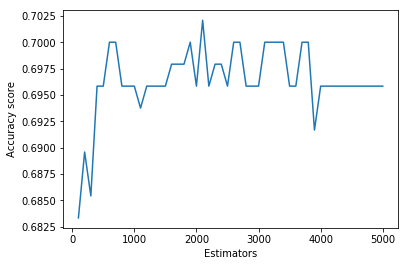

In [86]:
plt.plot(np.arange(100, 5001, 100), acc_score)
plt.xlabel('Estimators')
plt.ylabel('Accuracy score');

In [87]:
np.arange(100, 5001, 100)[acc_score.index(np.max(acc_score))]

2100

По графику видно, что до определенного количества простых алгоритмов в составе случайного леса, accuracy быстро растет, однако по достижению этого количества начинает то снижаться, то расти, а затем остается до стабилном уровне. Наибольшая доля правильных ответов была получена при n_estimators = 1200, при дальшейшем увеличении количества деревьев качество сниижается из-за переобучения (однако по графику нельзя сказать, что падение сильное, то есть динамика происходит на достаточно высоком уровне accuracy).

### IV. Нейронные сети

*На обучение нейросетей может уйти больше часа, не откладывайте этот пункт на последний день*.

__9 (1 балл)__

В этом задании вам предстоит обучить нейронную сеть на датасете [MNIST](https://en.wikipedia.org/wiki/MNIST_database) с помощью пакета [keras](https://keras.io).

Обучите нейронную сеть с двумя скрытыми слоями в каждой из которых поместите по 100 нейронов. Какого качества удается добиться на тесте?

In [113]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [114]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

In [115]:
from keras.utils import np_utils

x_train = x_train / 255
x_test = x_test / 255

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [116]:
earlystopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=3,verbose=0, mode='auto')

In [117]:
x_train.shape

(60000, 28, 28)

In [118]:
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [119]:
model.fit(x=x_train, y=y_train, batch_size=200, epochs = 20, verbose=1, validation_data=(x_test, y_test), callbacks = [earlystopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 59us/step - loss: 0.4040 - acc: 0.8888 - val_loss: 0.1890 - val_acc: 0.9437
Epoch 2/20
60000/60000 [==============================] - 3s 49us/step - loss: 0.1630 - acc: 0.9528 - val_loss: 0.1365 - val_acc: 0.9583
Epoch 3/20
60000/60000 [==============================] - 3s 44us/step - loss: 0.1189 - acc: 0.9648 - val_loss: 0.1086 - val_acc: 0.9672
Epoch 4/20
60000/60000 [==============================] - 3s 47us/step - loss: 0.0918 - acc: 0.9730 - val_loss: 0.0953 - val_acc: 0.9710
Epoch 5/20
60000/60000 [==============================] - 3s 47us/step - loss: 0.0744 - acc: 0.9779 - val_loss: 0.0925 - val_acc: 0.9709
Epoch 6/20
60000/60000 [==============================] - 3s 43us/step - loss: 0.0601 - acc: 0.9818 - val_loss: 0.0842 - val_acc: 0.9742
Epoch 7/20
60000/60000 [==============================] - 3s 42us/step - loss: 0.0508 - acc: 0.9845 - val_loss: 0.0786 - val_acc

In [120]:
model.evaluate(x_test, y_test)[1]

10000/10000 [==============================] - 1s 58us/step


0.97699999999999998

In [94]:
model.fit(x = x_train, y = y_train, epochs=10, batch_size=100, verbose=1)

Epoch 1/10
60000/60000 [==============================] - 4s 68us/step - loss: 0.3094 - acc: 0.9120
Epoch 2/10
60000/60000 [==============================] - 3s 56us/step - loss: 0.1300 - acc: 0.9616
Epoch 3/10
60000/60000 [==============================] - 5s 76us/step - loss: 0.0914 - acc: 0.9718
Epoch 4/10
60000/60000 [==============================] - 5s 88us/step - loss: 0.0679 - acc: 0.9798: 1s - loss
Epoch 5/10
60000/60000 [==============================] - 3s 43us/step - loss: 0.0528 - acc: 0.9842
Epoch 6/10
60000/60000 [==============================] - 2s 40us/step - loss: 0.0462 - acc: 0.9852
Epoch 7/10
60000/60000 [==============================] - 2s 40us/step - loss: 0.0356 - acc: 0.9892
Epoch 8/10
60000/60000 [==============================] - 3s 43us/step - loss: 0.0310 - acc: 0.9907
Epoch 9/10
60000/60000 [==============================] - 3s 48us/step - loss: 0.0239 - acc: 0.9927
Epoch 10/10
60000/60000 [==============================] - 3s 49us/step - loss: 0.0223 - 

In [95]:
model.evaluate(x_test, y_test)[1]

10000/10000 [==============================] - 1s 67us/step


0.97840000000000005

__10 (2 балл)__
Добавьте сверточные и pooling слои (вы можете также убрать Dense слои), добейтесь большего качества. Для успешного выполнения задания получите accuracy больше 0.99 на тестовой выборке. 

Рекомендации: после сверточных слоев наиболее эффективно добавлять MaxPooling слои, в конце перед последним слоем поставьте Dense слои с достаточно большим количеством нейронов. Подвигайте количество слоев, learning rate, функции активации.

In [121]:
x_train = x_train.reshape([-1, 28, 28, 1])
x_test = x_test.reshape([-1, 28, 28, 1])

In [122]:
model = Sequential()

model.add(Conv2D(32, kernel_size = (3, 3), activation = 'selu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

model.add(Dense(300, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [123]:
model.fit(x=x_train, y=y_train, batch_size=200, epochs = 20, verbose=1, validation_data=(x_test, y_test), callbacks = [earlystopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 86s 1ms/step - loss: 0.2168 - acc: 0.9363 - val_loss: 0.0574 - val_acc: 0.9822
Epoch 2/20
60000/60000 [==============================] - 79s 1ms/step - loss: 0.0561 - acc: 0.9824 - val_loss: 0.0401 - val_acc: 0.9863
Epoch 3/20
60000/60000 [==============================] - 77s 1ms/step - loss: 0.0407 - acc: 0.9875 - val_loss: 0.0372 - val_acc: 0.9865
Epoch 4/20
60000/60000 [==============================] - 91s 2ms/step - loss: 0.0310 - acc: 0.9904 - val_loss: 0.0320 - val_acc: 0.9882
Epoch 5/20
60000/60000 [==============================] - 89s 1ms/step - loss: 0.0231 - acc: 0.9928 - val_loss: 0.0301 - val_acc: 0.9905
Epoch 6/20
60000/60000 [==============================] - 114s 2ms/step - loss: 0.0174 - acc: 0.9947 - val_loss: 0.0350 - val_acc: 0.9895
Epoch 7/20
60000/60000 [==============================] - 78s 1ms/step - loss: 0.0143 - acc: 0.9955 - val_loss: 0.0331 - val_ac

In [124]:
model.evaluate(x_test, y_test)[1]

10000/10000 [==============================] - 7s 723us/step


0.98950000000000005

Мы получили качество на трейне и на тесте выше, чем в предыдущем случае. Оказалось достаточно 8 эпох.

__11 (1 балл)__
Добавьте 1 или 2 dropout слоя внутрь сети предыдущего шага. Удается ли добиться большего качества? Что происходит с процессом обучения? 

In [125]:
model = Sequential()

model.add(Conv2D(32, kernel_size = (3, 3), activation = 'selu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(300, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation = 'softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [126]:
model.fit(x=x_train, y=y_train, batch_size=200, epochs = 20, verbose=1, validation_data=(x_test, y_test), callbacks = [earlystopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 90s 1ms/step - loss: 0.2219 - acc: 0.9337 - val_loss: 0.0513 - val_acc: 0.9845
Epoch 2/20
60000/60000 [==============================] - 81s 1ms/step - loss: 0.0670 - acc: 0.9787 - val_loss: 0.0366 - val_acc: 0.9870
Epoch 3/20
60000/60000 [==============================] - 84s 1ms/step - loss: 0.0485 - acc: 0.9851 - val_loss: 0.0321 - val_acc: 0.9887
Epoch 4/20
60000/60000 [==============================] - 82s 1ms/step - loss: 0.0389 - acc: 0.9881 - val_loss: 0.0290 - val_acc: 0.9898
Epoch 5/20
60000/60000 [==============================] - 85s 1ms/step - loss: 0.0296 - acc: 0.9907 - val_loss: 0.0263 - val_acc: 0.9905
Epoch 6/20
60000/60000 [==============================] - 81s 1ms/step - loss: 0.0269 - acc: 0.9914 - val_loss: 0.0266 - val_acc: 0.9917
Epoch 7/20
60000/60000 [==============================] - 85s 1ms/step - loss: 0.0224 - acc: 0.9925 - val_loss: 0.0284 - val_acc

11 эпох оказалось достаточно в данном случае. Качество на трейновой выборке ниже, чем без dropout слоев, посмотрим, какое качество получается на тестовой выборке

In [127]:
model.evaluate(x_test, y_test)[1]

10000/10000 [==============================] - 6s 593us/step


0.99060000000000004

При добавлении dropout слоев мы полуачем более высокое качество на тестовой выборке. Это достаточно ожидаемый результат, потому что введение dropout слоев приводит к выключение части нейронов, то есть в принципе нужно для борьбы с переобучением. 